# Human stress prediction
**Business understanding**

The goal of this analysis is to be able to predict whether someone is stressed based on text.

The dataset contains data posted on subreddits related to mental health. This dataset contains various mental health problems shared by people about their life and labels to classify them as `Stress` or `No stress`.

The labelling method was not elaborated on by the source.
## Importing used libraries


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_recall_fscore_support


## Basic reusable function to quickly test models

To reduce redundancy and be able to more easily compare different models, I made a basic function that produces a **confusion_matrix** and **classification_report** and takes the data and initialized model as parameter inputs. The function really works the same as how you would normally test a model but with the hardcoded values replaced with parameters.

In [30]:
def test_model(Model, Xtrain, Ytrain, Xtest, Ytest):
    Model.fit(Xtrain,Ytrain) #Fit the model
    Model.score(Xtest,Ytest) #Determine the score of the model
    
    Model_Prediction = Model.predict(Xtest)
    accuracy = Model.score(Xtest, Ytest)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(Ytest, Model_Prediction, labels=Model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Model.classes_)
    disp.plot()
    plt.show()

    # Print classification report to check the classification performance
    print(classification_report(Ytest, Model_Prediction, target_names=Model.classes_))

## Data understanding

the `label` column contains 0 for `No Stress` and 1 for `Stress`. `Subreddit` contains the subreddit the text was taken from, subreddits are communities on the social media platform Reddit.
`post_id` contains the reddit post identifier, this is irrelevant data for the analysis. `sentence_range` contains ranges for the number of characters in the text. `Confidence` likely indicates how confident the source was of the label being correct. The meaning or usecase of the `social_timestamp` column is unknown.

Notes:
- The labels are fairly equally represented with a 52% positive labels and 48% negative labels.
- sentence_range, post_id, subreddit and social timestamp should probably be dropped due to either being unnecessary or in the case of subreddit likely leading to overfitting. 
- For simplicity and because there is some uncertainty of the meaning, confidence shouldn't be used in initial tests.
- None of the columns contain null values and considering the many to be dropped columns, very little data preperation is needed.

In [31]:
URL = "https://raw.githubusercontent.com/GitJvG/Dataset/refs/heads/main/Stress.csv"

df = pd.read_csv(URL)
print(df.info())
print(df.head(5))

print(df['label'].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB
None
          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge.

## Data preparation

First the labels are converted to categorical strings. This is done to improve readability and not strcitly necessary.

The top 1000 features from the text column are vectorized. This creates a matrix with numerical representations of the words. Changing the max_features value doesn't majorly impact the model's performance unless you decrease or increase it by a lot. This, however, isn't an parameter with a lot of performance improvement potential beyond what is currently achieved.

A dataframe with vectorized words is created. It uses get_feature_names_out to display the actual words instead of the vectorized numbers. The dataframe however still contains the vectorized values. The displayed words are simply labels to improve readability.

I decied to convert the binary classification of `label` to the category type with the `label_in_value` column for readability purposes. This is not necessary as the model can be directly trained on the binary label.

A simple train_test_split is performed to quickly split the dataset after which the custom model testing function is used to generate a confusion matrix and classification report.


    10  100   12   15   16   17   18   20   24   30  ...      year     years  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.070487  0.000000   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000  0.000000   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.104513  0.093983   

   yes  yesterday  yet       you  young  younger      your  yourself  
0  0.0   0.000000  0.0  0.078740    0.0      0.0  0.000000       0.0  
1  0.0   0.000000  0.0  0.192972    0.0      0.0  0.000000       0.0  
2  0.0   0.113784  0.0  0.099771    0.0      0.0  0.071922       0.0  
3  0.0   0.000000  0.0  0.032035    0.0      0.0  0.000000       0.0  
4  0.0   0.000000  0.0  0.000000    0.0      0.0  0.000000       0.0  

[5 rows x 1000 columns]
Test Accuracy: 73.24%


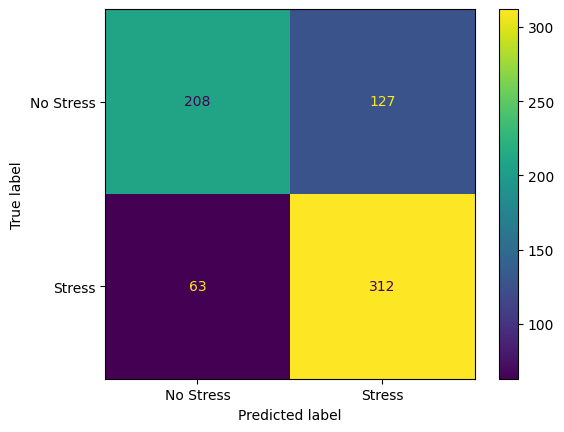

              precision    recall  f1-score   support

   No Stress       0.77      0.62      0.69       335
      Stress       0.71      0.83      0.77       375

    accuracy                           0.73       710
   macro avg       0.74      0.73      0.73       710
weighted avg       0.74      0.73      0.73       710



In [32]:
df['label_in_value']=df['label'].map({0:'No Stress',1:"Stress"})
catType = pd.CategoricalDtype(categories=["Stress", "No Stress"], ordered=False)
df['type'] = df['label_in_value'].astype(catType)

# Vectorizing the text to be able to calculate similarity with the model.
vectorizer = TfidfVectorizer(max_features=1000)
vectors = vectorizer.fit_transform(df.text)

"""Creating dummy columns for every word in the text column that contain 1 or 0 depending on whether they exist in the text of that row"""
wordsDF = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())
print(wordsDF.head())

"""Splitting the data into test and train datasets, This could be improved by using Kfold so all data is used for training"""
xTrain, xTest, yTrain, yTest = train_test_split(wordsDF, df.type, random_state=42)

"""Initializing the bayes model"""
bayes = MultinomialNB()
# Fitting the model
bayes.fit(xTrain, yTrain)

test_model(bayes, xTrain, yTrain, xTest, yTest)


## Evaluation

The model works fairly well, with an average accuracy of 70-75%, there are however several ways to improve the model. The model's performance significantly varies for different runs (when the fixed random_state is removed), indicating the train_test_split has a significant impact on the model's performance. This most likely has such a big effect because of the relatively small size of the dataset.

To improve the model's performance and consistency an obvious modification to attempt is to switch from the train_test_split method to K-fold Cross-Validation. By using K-fold Cross-Validation you ensure the data uses everything from the dataset as training and evaluation data without compromising its integrity.

The following code defines a function that performs K-fold Cross-validation and calculates the averages of all metrics separately over the folds to generate a custom 'average' classification report.

In [33]:
def test_model_kfold(Model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    precision_acc, recall_acc, f1_acc, support_acc, accuracy_acc = [], [], [], [], []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test)

        # Calculate precision, recall, f1-score, and support for each fold
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=Model.classes_)
        
        # Append fold-wise results
        precision_acc.append(precision)
        recall_acc.append(recall)
        f1_acc.append(f1)
        support_acc.append(support)
        accuracy_acc.append(accuracy_score(y_test, y_pred))

    # Calculate averages over all folds
    results = pd.DataFrame({
        "Class": Model.classes_,
        "Precision": np.mean(precision_acc, axis=0),
        "Recall": np.mean(recall_acc, axis=0),
        "F1-Score": np.mean(f1_acc, axis=0),
        "Support": np.sum(support_acc, axis=0).astype(int)
    })

    print(results.to_string(index=False))
    print(f"\nAverage Accuracy: {np.mean(accuracy_acc) * 100:.2f}%")

## Training and evaluating the Naive Bayes model with K-fold Cross-Validation

In the following code the Naive Bayes model is trained and evaluated using K-fold instead of train_test_split. 

The model's performance is not significantly better than the train_test_split model but it is still a consistent improvement across the board.

In [34]:
# Setting up KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 splits, shuffle the data

test_model_kfold(bayes, wordsDF, df.type)

    Class  Precision   Recall  F1-Score  Support
No Stress   0.778555 0.634788   0.69846     1350
   Stress   0.715702 0.836207   0.77062     1488

Average Accuracy: 73.96%


## Creating wordclouds for the categories

To get an idea of what words the model might be triggered by when classifying the text records and to get a better understanding of the data, wordclouds for `Stress` and `No Stress` are made.

The data preperation differs slighly because a vectorized matrix is created for both categories seperately. These are then both converted into dataframes like before to be able to rank the words from most to least used.

Generating the wordclouds is only a matter of using the wordcloud library and using matplotlib for formatting.

These wordclouds aren't very interesting though because they contain a lot of stopwords. Fortunately it's easy to filter out the stop words using the STOPWORDS argument. This has to be done at the vectorizing stage, a lot of duplicate code is required, for this reason it was put in a seperate code box.

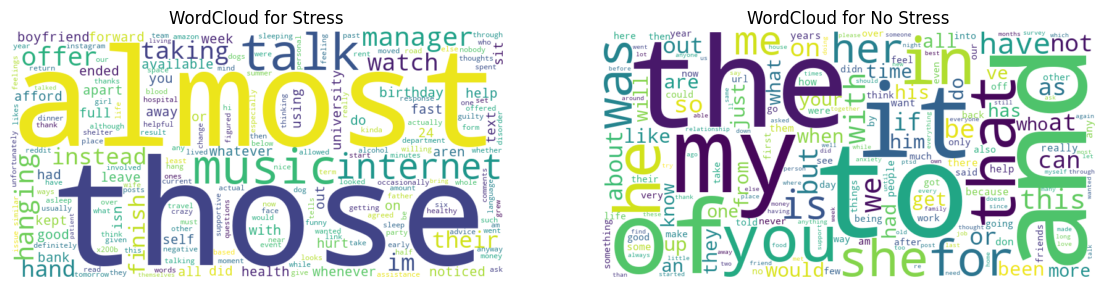

In [35]:
# Separate the texts into "Stress" and "No Stress" categories
stress_text = df[df['label_in_value'] == 'Stress']['text']
no_stress_text = df[df['label_in_value'] == 'No Stress']['text']

# Vectorize the text
vectorizer = TfidfVectorizer(max_features=1000)
stress_vectorized = vectorizer.fit_transform(stress_text)
no_stress_vectorized = vectorizer.fit_transform(no_stress_text)

# Convert to DataFrame for easier handling
stress_words_df = pd.DataFrame(stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
no_stress_words_df = pd.DataFrame(no_stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

# Sum and sort the TF-IDF values for each word
stress_word_freq = stress_words_df.sum().sort_values(ascending=False)
no_stress_word_freq = no_stress_words_df.sum().sort_values(ascending=False)

# Generate word cloud for Stress and No Stress
stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(stress_word_freq)
no_stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(no_stress_word_freq)

# Plot the word clouds side by side
plt.figure(figsize=(14, 7))

# WordCloud for Stress
plt.subplot(1, 2, 1)
plt.imshow(stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Stress')

# WordCloud for No Stress
plt.subplot(1, 2, 2)
plt.imshow(no_stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for No Stress')

plt.show()


## Wordclouds without English stop words

Mostly the same code as the previous approach wexcept now with stop words remopved using the `stop_words='english'` parameter in the vectorizer.

The results of removing stop words seem more interesting, although one could argue why some stopwords might be used more in `stress`/`no stress` texts is value information as well. Thus both were included in this notebook.

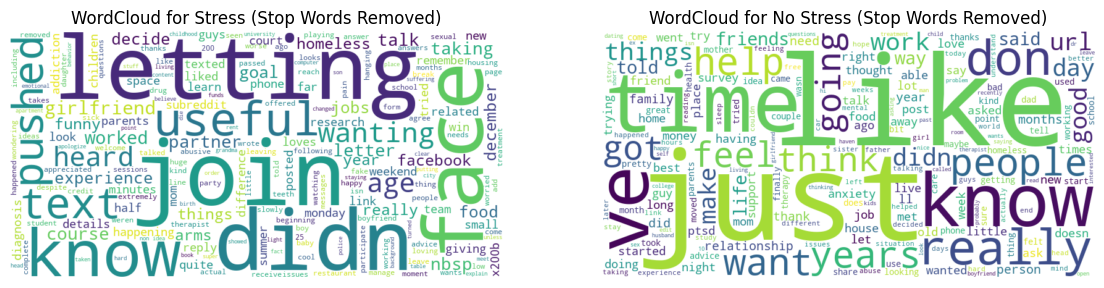

In [36]:
# Use TfidfVectorizer with stop words removed
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# The rest is the same as before
stress_vectorized = vectorizer.fit_transform(stress_text)
no_stress_vectorized = vectorizer.fit_transform(no_stress_text)

stress_words_df = pd.DataFrame(stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
no_stress_words_df = pd.DataFrame(no_stress_vectorized.toarray(), columns=vectorizer.get_feature_names_out())

stress_word_freq = stress_words_df.sum().sort_values(ascending=False)
no_stress_word_freq = no_stress_words_df.sum().sort_values(ascending=False)

stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(stress_word_freq)
no_stress_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(no_stress_word_freq)

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Stress (Stop Words Removed)')

plt.subplot(1, 2, 2)
plt.imshow(no_stress_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for No Stress (Stop Words Removed)')

plt.show()

## Final experiment: Naive Bayes without English stop words

Creating the wordclouds without stopwords made me wonder whether the Naive Bayes model might perform better with these words removed as well. As a final experiment this will be done using the same Kfold approach as before.

In [37]:
# Use TfidfVectorizer with stop words removed
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
vectors = vectorizer.fit_transform(df.text)

"""Creating dummy columns for every word in the text column that contain 1 or 0 depending on whether they exist in the text of that row"""
wordsDF_no_stop_words = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names_out())

kf = KFold(n_splits=5, shuffle=True, random_state=42)

test_model_kfold(bayes, wordsDF_no_stop_words, df.type)

    Class  Precision   Recall  F1-Score  Support
No Stress   0.741651 0.606447  0.666474     1350
   Stress   0.693308 0.808627  0.745952     1488

Average Accuracy: 71.18%


## Final thoughts

**Stop words** 

Removing the stop words made the Naive Bayes model less accurate, this does seem to make sense as the wordclouds showed there was a clear distinction between frequently used stop words in `Stress` and `No Stress` cases, which indicates these can do a good job at classifying and don't just act as noise to the model. Still it is probably better to remove them in wordclouds as including the stopwords isn't as interesting and would probably cause the wordclouds of many different datasets to look very similar.

**Naive Bayes**

I am quite pleased with the performance of the Naive Bayes model that uses K-fold cross-validation and includes stop words. 77% precision on `No Stress` and 71% on `Stress` is not too bad considering the model was trained on text from Reddit posts. The model might be able to be improved by also including the subreddit column in the training, I do however feel like this would lead to overfitting and defeats the purpose of the model. Posts from a subreddit like `PTSD` will probably more often than not be stressed, but this would make the model more limitted to just being able to predict `Stress` or `No Stress` of reddit text.

Something I noticed at the very end is that the train_test_split using model varies **a lot** in the results it returns. This is almost certainly caused by the random split sometimes creating a 'golden' training or testing dataset that does a very good job at identifying features of the categories whilst at other times severly underperforming due to an unfortunate training or testing dataset. The K-fold driven model however returns the same scores on every run. Although you can sometimes randomly get a better model with the train_test_split model, I would greatly prefer a consistently fine performing model.

**Further model improvement**

 - Parameter tuning:
 
 I don't believe there is much to gain with parameter optimization of the current models. I have manually played around with the K-fold parameters but these only had a significant impact when made very small or very big. Everything between returned about the same results.
 
 - Confidence column:

 The dataset, other than the label column, also contained a confidence column which could be used to add further depth to the label. I didn't use this column for models in this notebook but I imagine better results could be achieved when this column is properly used.

 - senetence_range column:

 The training could be tested with this column as an extra feature. Looking back, this column probably should not have been dropped as text length might be a good indicator of stress or no stress.